In [1]:
# Imports and general setup

# needed for plotting with a notebook cell
%pylab inline

from __future__ import division # the python 3 division - outputs double instead of am int
from __future__ import print_function # the python 3 print function - print()
from tqdm import tqdm # library add a progrees bar for an iterating for loops

from explauto.environment import environments # library environment for modeling implementation

# pypot libraries - the lower level of the poppy framework
import pypot.dynamixel # library to control the servo motors
import pypot.robot  # pypot library for robtic controlss

import time,datetime # libraries to keep track of times
import threading  # library for multithreading workloads

import wave  # library for recording sound and exporting as a wave file
import alsaaudio, audioop, sys, librosa  # library for recording sound

import numpy as np # python's standard linear algebra library: needed for static arrays
import matplotlib.pyplot as plt # library for graphing data


# format for setting up the poppy arm pecause the poppy is not working for us yet
my_config ={}
my_config['controllers'] = {}
my_config['controllers']['upper_body_controler'] = {
    'port': '/dev/ttyUSB0',     # For Linux
    #'port': '/dev/tty.usbserial-AI03QEN0', # For OSX
    'sync_read': False,
    'attached_motors': ['arms'],
    'protocol': 1,
}
my_config['motorgroups']={}
my_config['motorgroups'] = {
    'arms': ['right_arm'],
    'right_arm': ['r_shoulder_x', 'r_shoulder_y', 'r_arm_z','r_elbow_y']
}
my_config['motors'] = {}
my_config['motors']['r_shoulder_y'] = {
    'id': 51,
    'type': 'MX-28',
    'orientation': 'indirect',
    'offset': 0.0,
    'angle_limit': (-50, 170),
}
my_config['motors']['r_shoulder_x'] = {
    'id': 52,
    'type': 'MX-28',
    'orientation': 'indirect',
    'offset': 0.0,
    'angle_limit': (-90, 0),
}
my_config['motors']['r_arm_z'] = {
    'id': 53,
    'type': 'MX-28',
    'orientation': 'indirect',
    'offset': 0.0,
    'angle_limit': (-20, 95),
}
my_config['motors']['r_elbow_y'] = {
    'id': 54,
    'type': 'MX-28',
    'orientation': 'indirect',
    'offset': 0.0,
    'angle_limit': (0, 130),
}

poppy = pypot.robot.from_config(my_config)  # initiates the poppy object

poppy.start_sync()  # sync the motors so he
time.sleep(2)  # pauses the program 


# for loop primes the motors to be programmed
for m in poppy.motors:
    m.compliant = False
    m.goto_behavior = 'minjerk' # prevents jerky movements

# arrays to store data
pos = []  # stores the angle position of all the motors at a given point in time
TIME = []  # stores a timestamp of when an action is occuring
sys_load = []  # stores the load (stress) the motors or under at any one time
speed = []  # stores the angle speed the motors are moving at any one time
temp = []  # stores the temperature of the motors at any point in time
volt = []  # stores the voltage going through each motor at any one time

# specific arrays for the rattle shaking movement
data_table = []  # stores the sound features of a recording
spike = [[],[]]  # stores instances of abnormal spikes in sound features and a given timestamp


# activate microphone - A Logitech webcam
inp = alsaaudio.PCM(alsaaudio.PCM_CAPTURE,alsaaudio.PCM_NONBLOCK,device='sysdefault:CARD=C920')
inp.setchannels(2)
inp.setrate(88200)  # while 44100 is normal, as it is the default in software like Audacity, it is
inp.setformat(alsaaudio.PCM_FORMAT_GSM)
inp.setperiodsize(160)




Populating the interactive namespace from numpy and matplotlib


2822L

In [42]:
# Primitive actions

# pute the arm in an "attention" stance
def rest_position():
    poppy.r_shoulder_x.goal_position = 0
    poppy.r_shoulder_y.goal_position = 0
    poppy.r_arm_z.goal_position = 0
    poppy.r_elbow_y.goal_position = 0

# stores data from the motors about their various statistics
def app():
    # stores the angle position of all the motors
    pos.append(poppy.r_shoulder_x.present_position)
    pos.append(poppy.r_shoulder_y.present_position)
    pos.append(poppy.r_arm_z.present_position)
    pos.append(poppy.r_elbow_y.present_position)

    # stores the load on all the motors
    sys_load.append(poppy.r_shoulder_x.present_load)
    sys_load.append(poppy.r_shoulder_y.present_load)
    sys_load.append(poppy.r_arm_z.present_load)
    sys_load.append(poppy.r_elbow_y.present_load)
    
    # stores the angle speed the motors are traveling at
    speed.append(poppy.r_shoulder_x.present_speed)
    speed.append(poppy.r_shoulder_y.present_speed)
    speed.append(poppy.r_arm_z.present_speed)
    speed.append(poppy.r_elbow_y.present_speed)
    
    # stores the tempurature of the motors
    temp.append(poppy.r_shoulder_x.present_temperature)
    temp.append(poppy.r_shoulder_y.present_temperature)
    temp.append(poppy.r_arm_z.present_temperature)
    temp.append(poppy.r_elbow_y.present_temperature)
    
    # stores the current voltage a load is requiring the motors to use
    volt.append(poppy.r_shoulder_x.present_voltage)
    volt.append(poppy.r_shoulder_y.present_voltage) 
    volt.append(poppy.r_arm_z.present_voltage)
    volt.append(poppy.r_elbow_y.present_voltage)
    
# funcion makes the arm do a basic arm wave by moving between two point in space
def hand_wave(sec=10, rest=0.5):  # default sec is how long the program is set to run for || default rest period indicates breakpoint joint has to finish a motion
    t0 = time.time() # marks a starting time for the hand wave motion
    while True:  # loop
        
        t1 = time.time() # this time gets updated at each loop
        if t1-t0 >= sec:  # difference between t1 and t0 indicates elapsed time
            break  # when time elapsed exceeds alotted runtime loop is exited

        
        # The following commands move the arm to the first position
        
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_y.goal_position = -70
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_x.goal_position = -170  
        app()
        TIME.append(t1-t0)
        poppy.r_arm_z.goal_position = 60;
        app()
        TIME.append(t1-t0)
        poppy.r_elbow_y.goal_position = 125
        
        app()
        TIME.append(t1-t0)
        time.sleep(rest)
        
        
        # The following commands move the arm to the first position
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_y.goal_position = -50
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_x.goal_position = -135
        app()
        TIME.append(t1-t0)
        poppy.r_arm_z.goal_position = 75
        app()
        TIME.append(t1-t0)
        poppy.r_elbow_y.goal_position = 90
        
        app()
        TIME.append(t1-t0)

        time.sleep(rest)
        app()

        
# function makes the arm shake a rattle
def rattle_shake(sec=20, rest=.4):
    
    # define the first point in space
    shoulder_y0 = -45
    shoulder_x0 = 0
    arm_0 = 0
    elbow_0 = -65
    
    # define the second point in space
    shoulder_y1 = -30
    shoulder_x1 = 0
    arm_1 = 0
    elbow_1 = -35
    
    # speed adjustments to be more infant like
    poppy.r_shoulder_y.moving_speed = abs(shoulder_y1-shoulder_y0) / rest
    poppy.r_shoulder_x.moving_speed = abs(shoulder_x1-shoulder_x0) / rest
    poppy.r_arm_z.moving_speed = abs(arm_1-arm_0) / rest
    poppy.r_elbow_y.moving_speed = abs(elbow_1-elbow_0) / rest

    t0 = time.time()
    while True:
              
        t1 = time.time() # this time gets updated at each loop
        if t1-t0 >= sec:  # difference between t1 and t0 indicates elapsed time
            break  # when time elapsed exceeds alotted runtime loop is exited
            
        

        # arm moves to first position
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_y.goal_position = shoulder_y0 #-45
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_x.goal_position = shoulder_x0 #5
        app()
        TIME.append(t1-t0)
        poppy.r_arm_z.goal_position = arm_0 #20
        app()
        TIME.append(t1-t0)
        poppy.r_elbow_y.goal_position = elbow_0 #-129
        

        
        app()
        TIME.append(t1-t0)
        time.sleep(rest)
        
        
        # arm moves to second position
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_y.goal_position = shoulder_y1 #-25
        app()
        TIME.append(t1-t0)
        poppy.r_shoulder_x.goal_position = shoulder_x1  #0
        app()
        TIME.append(t1-t0)
        poppy.r_arm_z.goal_position = arm_1; #0
        app()
        TIME.append(t1-t0)
        poppy.r_elbow_y.goal_position = elbow_1 #-10
        


       
        app()
        TIME.append(t1-t0)
        time.sleep(rest)
        
        
        
        app()
        TIME.append(t1-t0)
    

    
    # resets motor speed
    for x in poppy.motors:
            x.moving_speed = 90


In [43]:
#This script is used to move the poppy arm into anatomical poses.
#Pictures will be edited for an anatomical reference.
def anatomical(rest=3):
        time.sleep(rest)
#Lateral View Pictures
#Figure 1
    #Motor 51 Shoulder Flexion
        poppy.r_shoulder_y.goal_position = 49 
        time.sleep(rest)
        #Rest Position
        rest_position()
    #Motor 51 Shoulder Extension
        poppy.r_shoulder_y.goal_position = -169 
        time.sleep(rest)
        #Rest Position
        rest_position()
#Figure 2
    #Motor 54 Elbow Extension
        poppy.r_elbow_y.goal_position = 0 
        time.sleep(rest)
        #Rest Position
        rest_position()
    #Motor 54 Elbow Flexion
        poppy.r_elbow_y.goal_position = -129
        time.sleep(rest)
        #Rest Position
        rest_position()
            
#Anterior View Pictures
#Figure 3
    #Motor 53 Pronation
        poppy.r_arm_z.goal_position = -20 
        time.sleep(rest)
        #Rest Position
        rest_position()
    #Motor 53 Supination
        poppy.r_arm_z.goal_position = 94 
        time.sleep(rest)
        #Rest Position
        rest_position()
#Figure 4       
    #Motor 52 Adduction
        poppy.r_shoulder_x.goal_position = 0
        time.sleep(rest)
        #Rest Position
        rest_position()
    #Motor 52 Abduction    
        poppy.r_shoulder_x.goal_position = 89
        time.sleep(rest)
        #Rest Position
        rest_position()



In [44]:
# audio recording setup
# creates a new wavefile for each run
def outFile():
    return "../out_Data/rattle_{}.wav".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S'))

In [45]:
# this cell is for resetting the arm to a resting position
rest_position()
data_table=[]
spike = [[],[]]

In [46]:
# function causes the rattle to shake and record audio
def alsa_rattle():
    # set up the wave file
    w = wave.open(outFile(),'w')
    # Open the device in nonblocking capture mode. The last argument could
    # just as well have been zero for blocking mode. Then we could have
    # left out the sleep call in the bottomvim of the loop

    w.setnchannels(2)
    w.setsampwidth(2)
    w.setframerate(44100)

    total = 0
    
    # allows function to run in parallel
    t = threading.Thread(target=rattle_shake)
    t.start()
    timeStart = time.time()
    while t.is_alive():
        timeStop = time.time()
        l,data = inp.read()
        if l:
            # Return the maximum of the absolute value of all samples in a fragment.
            frame = audioop.max(data,2)
            data_table.append(frame)
            total += frame
            ave = total / len(data_table)
            if(len(data_table) > 25) :
                if (frame > ave * 1.34):
                    spike[0].append(timeStop - timeStart)
                    spike[1].append(frame)
            w.writeframes(data)
            # print audioop.max(data, 2)
        time.sleep(.001)
    rest_position()

In [47]:
# execute the rattle command
alsa_rattle()
rest_position()

In [39]:
len(spike[0])

56

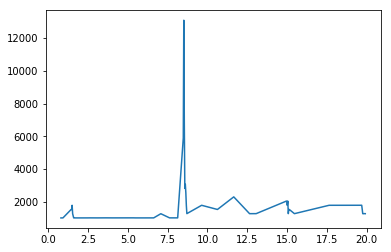

In [40]:
plt.plot(spike[0],spike[1])

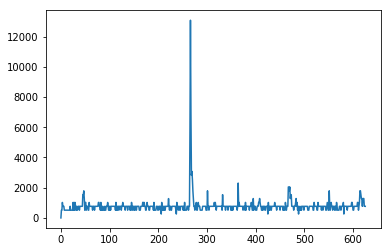

In [41]:
plt.plot(data_table)

In [25]:
for x in poppy.motors:
    print(x.moving_speed)

90
90
90
90


In [105]:
poppy.r_shoulder_y.goal_position = -45 #-10
poppy.r_shoulder_x.goal_position = 5  #0
poppy.r_arm_z.goal_position = 20; #0
poppy.r_elbow_y.goal_position = -65 #0

In [104]:
poppy.r_shoulder_y.goal_position = -30 #-10
poppy.r_shoulder_x.goal_position = 0  #0
poppy.r_arm_z.goal_position = 0; #0
poppy.r_elbow_y.goal_position = -35 #0

In [6]:
rattle_shake(sec=4)
rest_position()

In [49]:
# RUN at the end of working

pos = []
TIME = []
sys_load = []
speed = []
temp = []
volt = []
data_table = []
spike = [[],[]]
for m in poppy.motors:
    m.compliant = True
time.sleep(1)
poppy.stop_sync()
poppy.close()